In [1]:
from framework.simulation import FaradayThinSource,FaradayThickSource
from framework.reconstruction import Parameter
import numpy as np
from IPython.display import clear_output
from framework.io import Reader, Writer
from framework.base import Dataset
from framework.transformers import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from framework.objectivefunction import OFunction
from framework.utils import real_to_complex, complex_to_real, find_pixel
from framework.objectivefunction import TSV, TV, L1, Chi2
from framework.optimization import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.utils import Gaussian
from framework.dictionaries.discrete import DiscreteWavelet
from framework.dictionaries.undecimated import UndecimatedWavelet
from framework.transformers import Gridding
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools
import copy

np.random.seed(666)

In [2]:
class Test:
    def __init__(self, nu_min=None, nu_max=None, nchannels=None, noise_frac=None, remove_frac=None, use_gridding=False, ftransform="nufft", use_wavelet=None, source_1=None, source_2=None, scenario=1):
        self.nu_min = nu_min
        self.nu_max = nu_max
        self.nchannels = nchannels
        self.noise_frac = noise_frac
        self.remove_frac = remove_frac
        self.use_gridding=use_gridding
        self.use_wavelet = use_wavelet
        self.ftransform = ftransform
        self.scenario = scenario
        self.nu = np.linspace(start=nu_min, stop=nu_max, num=nchannels)
        self.source_1 = copy.deepcopy(source_1)
        self.source_2 = copy.deepcopy(source_2)

        if self.source_1 is not None:
            self.source_1.nu = self.nu
            self.source_1.simulate()
                
        if self.source_2 is not None:
            self.source_2.nu = self.nu
            self.source_2.simulate()
                
        if scenario == 1:
            self.source = self.source_1
        elif scenario == 2:
            self.source = self.source_2
        else:
            self.source = self.source_1 + self.source_2
            
        if remove_frac:
            self.source.remove_channels(remove_frac)
        
        self.noiseless_source = copy.deepcopy(self.source)
        
        if noise_frac:
            if scenario == 1:
                self.avg_signal = np.abs(self.source_1.s_nu)
            elif scenario == 2:
                self.avg_signal = np.abs(self.source_2.s_nu)
            else:
                self.avg_signal = (np.abs(self.source_1.s_nu) + np.abs(self.source_2.s_nu))/2.0
            self.source.apply_noise(self.avg_signal/self.noise_frac)
                
        if use_gridding:
            gridding = Gridding(self.source)
            gridding_noiseless = Gridding(self.noiseless_source)
            self.source = gridding.run()
            self.noiseless_source = gridding_noiseless.run()
            
    def run(self, lambda_tv:float=None, lambda_tsv:float=None):
        self.parameter = Parameter()
        self.parameter.calculate_cellsize(dataset=self.source)
        
        dft = DFT1D(dataset=self.source, parameter=self.parameter)
        
        self.F_dirty = dft.backward(self.source.data)
        
        idx_noise = np.where(np.abs(self.parameter.phi)>self.parameter.max_faraday_depth/1.5)
        
        self.noise = 0.5*(np.std(self.F_dirty[idx_noise].real) + np.std(self.F_dirty[idx_noise].imag))
        
        if self.use_wavelet:
            #self.wavelet = DiscreteWavelet(wavelet_name=self.use_wavelet, mode="periodization")
            self.wavelet = UndecimatedWavelet(wavelet_name=self.use_wavelet)
        
        self.lambda_l1 = np.sqrt(2.0 * len(self.source.data) + 4.0 * np.sqrt(len(self.source.data)))*self.noise*0.5
        #lambda_l1 =np.sqrt(len(self.source.data) + np.sqrt(len(self.source.data)))*self.noise
        
        
        if lambda_tv is None:
            lambda_tv = 0.0
        
        if lambda_tsv is None:
            lambda_tsv = 0.0
            
        if self.ftransform == "nufft":
            nufft = NUFFT1D(dataset=self.source, parameter=self.parameter, solve=True)
            if self.use_wavelet:
                chi2 = Chi2(dft_obj=nufft, wavelet=self.wavelet)
            else:
                chi2 = Chi2(dft_obj=nufft)
        else:
            if self.use_wavelet:
                chi2 = Chi2(dft_obj=dft, wavelet=self.wavelet)
            else:
                chi2 = Chi2(dft_obj=dft)
            
        l1 = L1(reg=self.lambda_l1)
        tsv = TSV(reg=lambda_tsv)
        tv = TV(reg=lambda_tv)
        F_func = [chi2, l1, tsv]
        f_func = [chi2]
        g_func = [l1, tsv]

        F_obj = OFunction(F_func)
        f_obj = OFunction(f_func)
        g_obj = OFunction(g_func)
        
        self.parameter.data = self.F_dirty
        
        self.parameter.complex_data_to_real()
        
        if self.use_wavelet:
            self.parameter.data = self.wavelet.decompose(self.parameter.data)
        
        opt = FISTA(guess_param=self.parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=self.noise, verbose=True)
        self.obj, self.X = opt.run()
        
        if self.use_wavelet is not None:
            self.coeffs = copy.deepcopy(self.X.data)
            self.sparsity = len(np.nonzero(self.coeffs))/len(self.coeffs)
            self.X.data = self.wavelet.reconstruct(self.X.data)
        else:
            self.sparsity = len(np.nonzero(self.X.data))/ len(self.X.data)
            
        
        self.X.real_data_to_complex()
        
        self.X_residual = dft.backward(self.source.residual)
        
        self.X_restored = self.X.convolve() + self.X_residual
        
        self.res_noise = 0.5*(np.std(self.X_residual.real) + np.std(self.X_residual.imag))
        meaningful_signal = np.where(np.abs(self.parameter.phi) < self.parameter.max_faraday_depth)
        self.signal = np.mean(np.abs(self.X_restored[meaningful_signal]))
        self.peak_signal = np.max(np.abs(self.X_restored))
        self.rmse = np.sqrt(np.mean(self.res_noise**2))
        
        self.snr = self.signal / self.res_noise
        self.psnr = self.peak_signal / self.res_noise
        
        print("Signal-to-noise ratio: {0}".format(self.snr))
        print("Peak Signal-to-noise ratio: {0}".format(self.psnr))
        print("Normalized Root Mean Squared Error: {0}".format(self.rmse))
        
        self.lags, self.autocorr_res, self.autocorr_res_sq, self.bound, self.percentage_real_in, self.percentage_imag_in, self.percentage_real_in_sq, self.percentage_imag_in_sq = self.source.assess_residuals()
        
        self.residual_comparison = self.noiseless_source.data - self.source.model_data
        
        self.fig, self.ax = plt.subplots(nrows=2, ncols=4, sharey='row', figsize=(18, 5))

        # Data
        self.ax[0,0].plot(self.source.lambda2, self.source.data.real, 'k.', label=r"Stokes $Q$")
        self.ax[0,0].plot(self.source.lambda2, self.source.data.imag, 'c.', label=r"Stokes $U$")
        self.ax[0,0].plot(self.source.lambda2, np.abs(self.source.data), 'g.', label=r"$|P|$")
        self.ax[0,0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
        self.ax[0,0].set_ylabel(r'Jy/beam')
        self.ax[0,0].title.set_text("Data")

        self.ax[1,0].plot(self.parameter.phi, self.F_dirty.real, 'c--', label=r"Stokes $Q$")
        self.ax[1,0].plot(self.parameter.phi, self.F_dirty.imag, 'c:', label=r"Stokes $U$")
        self.ax[1,0].plot(self.parameter.phi, np.abs(self.F_dirty), 'k-', label=r"|P|")
        self.ax[1,0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
        self.ax[1,0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
        self.ax[1,0].set_xlim([-1000,1000])

        # Model
        self.ax[0,1].plot(self.source.lambda2, self.source.model_data.real, 'k.', label=r"Stokes $Q$")
        self.ax[0,1].plot(self.source.lambda2, self.source.model_data.imag, 'c.', label=r"Stokes $U$")
        self.ax[0,1].plot(self.source.lambda2, np.abs(self.source.model_data), 'g.', label=r"$|P|$")
        self.ax[0,1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
        self.ax[0,1].set_ylabel(r'Jy/beam')
        self.ax[0,1].title.set_text("Model")

        self.ax[1,1].plot(self.parameter.phi, self.X.data.real, 'c--', label=r"Stokes $Q$")
        self.ax[1,1].plot(self.parameter.phi, self.X.data.imag, 'c:', label=r"Stokes $U$")
        self.ax[1,1].plot(self.parameter.phi, np.abs(self.X.data), 'k-', label=r"$|P|$")
        self.ax[1,1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
        self.ax[1,1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
        self.ax[1,1].set_xlim([-1000,1000])

        # Residual

        # Model
        self.ax[0,2].plot(self.source.lambda2, self.source.residual.real, 'k.', label=r"Stokes $Q$")
        self.ax[0,2].plot(self.source.lambda2, self.source.residual.imag, 'c.', label=r"Stokes $U$")
        self.ax[0,2].plot(self.source.lambda2, np.abs(self.source.residual), 'g.', label=r"$|P|$")
        self.ax[0,2].set_xlabel(r'$\lambda^2$[m$^{2}$]')
        self.ax[0,2].set_ylabel(r'Jy/beam')
        self.ax[0,2].title.set_text("Residual")

        self.ax[1,2].plot(self.parameter.phi, self.X_residual.real, 'c--', label=r"Stokes $Q$")
        self.ax[1,2].plot(self.parameter.phi, self.X_residual.imag, 'c:', label=r"Stokes $U$")
        self.ax[1,2].plot(self.parameter.phi, np.abs(self.X_residual), 'k-', label=r"$|P|$")
        self.ax[1,2].set_xlabel(r'$\phi$[rad m$^{-2}$]')
        self.ax[1,2].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
        self.ax[1,2].set_xlim([-1000,1000])
        
        if self.use_wavelet:
            self.ax[0,3].plot(self.coeffs)
            self.ax[0,3].title.set_text("Coefficients")

        self.ax[1,3].plot(self.parameter.phi, self.X_restored.real, 'c--', label=r"Stokes $Q$")
        self.ax[1,3].plot(self.parameter.phi, self.X_restored.imag, 'c:', label=r"Stokes $U$")
        self.ax[1,3].plot(self.parameter.phi, np.abs(self.X_restored), 'k-', label=r"$|P|$")
        self.ax[1,3].set_xlim([-1000,1000])
        self.ax[1,3].set_xlabel(r'$\phi$[rad m$^{-2}$]')
        self.ax[1,3].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
        self.ax[1,3].title.set_text("Restored")
        
        self.fig.tight_layout()

In [3]:
source_1 = FaradayThinSource(s_nu=0.0035, phi_gal=-200, spectral_idx=1.0)
source_2 = FaradayThickSource(s_nu=0.0035, phi_fg=140, phi_center=200, spectral_idx=1.0)

In [4]:
nsigma = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
remove_frac = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

In [5]:
test_objs = []
for nsig in nsigma:
    for remv_frac in remove_frac:
        test_objs.append(Test(nu_min=1.008e9, nu_max=2.031e9, nchannels=1000, noise_frac=nsig, remove_frac=remv_frac, scenario=1, source_1=source_1, source_2=source_2))

In [6]:
nid = len(nsigma)*len(remove_frac)
for _id in range(0, nid):
    test_objs[_id].run()

FWHM of the main peak of the RMTF: 51.962 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 25954.896
Iterations set to 23
Iteration:  0  objective function value: 0.00682
Signal-to-noise ratio: 1.3528829005770375
Peak Signal-to-noise ratio: 63.03979164903818
Normalized Root Mean Squared Error: 5.31883561052382e-05
FWHM of the main peak of the RMTF: 52.102 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 23419.848
Iterations set to 21
Iteration:  0  objective function value: 0.00760
Signal-to-noise ratio: 1.322867487058602
Peak Signal-to-noise ratio: 59.37577507994971
Normalized Root Mean Squared Error: 5.8522829931462184e-05
FWHM of the main peak of the RMTF: 54.537 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 21787.658
Iterations set to 20
Iteration:  0  ob

/tmp/ipykernel_115925/2774269971.py:141: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig, self.ax = plt.subplots(nrows=2, ncols=4, sharey='row', figsize=(18, 5))


FWHM of the main peak of the RMTF: 67.611 rad/m^2
Maximum recovered width structure: 130.153 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 16868.880
Iterations set to 16
Iteration:  0  objective function value: 0.00211
Signal-to-noise ratio: 1.4090681492070432
Peak Signal-to-noise ratio: 81.6551167749814
Normalized Root Mean Squared Error: 4.1131028410745785e-05
FWHM of the main peak of the RMTF: 65.042 rad/m^2
Maximum recovered width structure: 143.897 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 12975.851
Iterations set to 14
Iteration:  0  objective function value: 0.00209
Signal-to-noise ratio: 1.2821766492936253
Peak Signal-to-noise ratio: 60.0069876976284
Normalized Root Mean Squared Error: 4.9644797400105745e-05
FWHM of the main peak of the RMTF: 55.903 rad/m^2
Maximum recovered width structure: 128.912 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 8357.440
Iterations set to 12
Iteration:  0  ob

limit_output extension: Maximum message size of 10000 exceeded with 10233 characters

In [7]:
selected_test = test_objs[7]

In [8]:
selected_test.remove_frac

0.7

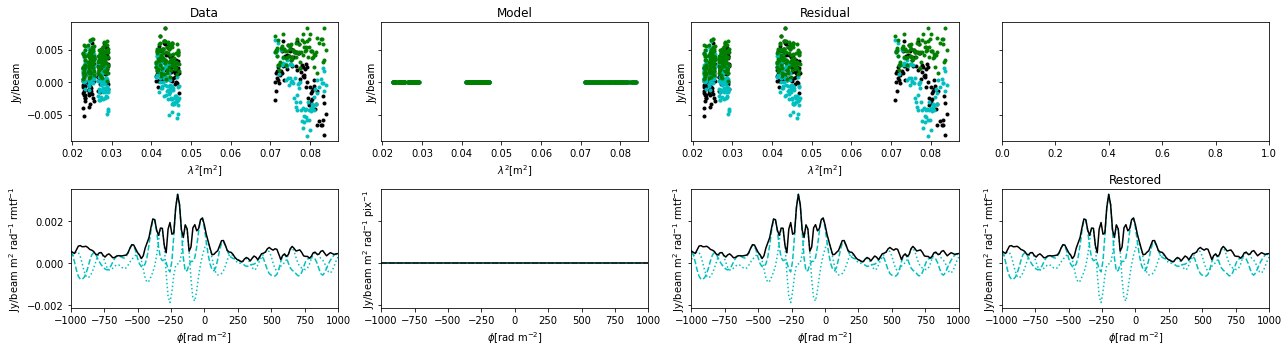

In [9]:
selected_test.fig

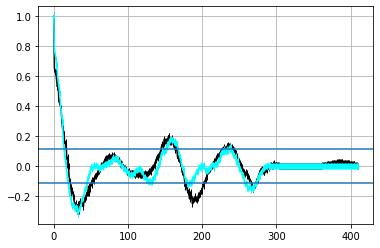

In [10]:
plt.plot(selected_test.lags, selected_test.autocorr_res.real, '|-', c="black", label=r"Real part")
plt.plot(selected_test.lags, selected_test.autocorr_res.imag, '|-', c="cyan", label=r"Imaginary part")
plt.axhline(-selected_test.bound)
plt.axhline(selected_test.bound)
plt.grid()

In [11]:
#from framework.base import boxpierce, ljungbox
#ljungbox(selected_test.autocorr_res.real, [1, 400, len(selected_test.lags)-1])

In [12]:
#boxpierce(selected_test.autocorr_res.real, [1, 400, len(selected_test.lags)-1])

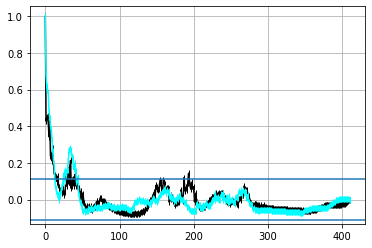

In [13]:
plt.plot(selected_test.lags, selected_test.autocorr_res_sq.real, '|-', c="black", label=r"Real part")
plt.plot(selected_test.lags, selected_test.autocorr_res_sq.imag, '|-', c="cyan", label=r"Imaginary part")
plt.axhline(-selected_test.bound)
plt.axhline(selected_test.bound)
plt.grid()

In [14]:
selected_test.percentage_real_in, selected_test.percentage_imag_in

(72.74939172749392, 80.5352798053528)

In [15]:
std_res_real = np.std(selected_test.source.residual.real)
print(std_res_real)

0.002648214694875201


In [16]:
std_res_imag = np.std(selected_test.source.residual.imag)
print(std_res_imag)

0.0028148064307869395


In [17]:
selected_test.avg_signal/selected_test.noise_frac

0.00175

In [18]:
import pandas as pd

In [19]:
pd.DataFrame(np.array_split([x.psnr for x in test_objs], len(nsigma)), columns=remove_frac, index=1/nsigma)

TypeError: unsupported operand type(s) for /: 'int' and 'list'

In [ ]:
pd.DataFrame(np.array_split([x.rmse for x in test_objs], len(nsigma)), columns=remove_frac, index=1/nsigma)

In [ ]:
pd.DataFrame(np.array_split([x.sparsity*100.0 for x in test_objs], len(nsigma)), columns=remove_frac, index=1/nsigma)

In [ ]:
# [0.2, 0.5, 0.7] Removal fraction [2, 5, 7]
# [2.0, 6.0, 10.0] Noise # [0, 4, 8]
"""
for i in [0, 4, 8]:
    for j in [2, 5, 7]:
        idx = len(remove_frac)*i + j
        #print(idx)
        selected_test = test_objs[idx]
        print(np.max(selected_test.source.lambda2))
        plt.clf()
        plt.plot(selected_test.source.lambda2, selected_test.source.data.real, 'k.', label=r"Stokes $Q$")
        plt.plot(selected_test.source.lambda2, selected_test.source.data.imag, 'c.', label=r"Stokes $U$")
        plt.plot(selected_test.source.lambda2, np.abs(selected_test.source.data), 'g.', label=r"$|P|$")
        if i==8:
            plt.xlabel(r'$\lambda^2$[m$^{2}$]')
        else:
            plt.xticks([])
        if j==2:
            plt.ylabel(r'Jy/beam')
        else:
            plt.yticks([])
        #plt.legend(loc=(1.04, 0.755), fancybox=True, shadow=True)
        plt.xlim([0.0,0.09])
        plt.ylim([-0.01,0.01])
        plt.tight_layout()
        plt.savefig("pol_sim_rem_"+str(remove_frac[j])+"_noise_"+str(nsigma[i])+"_"+str(idx)+".png", dpi=100)
"""